In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rubin_sim.maf as maf

In [2]:
runName = 'minion_1016_dc2'
opsdb_file = 'minion_1016_desc_dithered_v4_trimmed.db'

In [3]:
# The minion_1016 database is old -- it's opsim v3
# The default observations table is 'Summary'
# and the schema uses different column names - exposure MJD is 'expMJD' and the seeing is "FWHMeff", etc
# The other consideration is that Summary may contain duplicates of a given exposure .. however the DESC version 
# is already only unique visits, so no problem there
defaultTable = 'Summary'
colmap = maf.ColMapDict('opsimV3')
# colmap doesn't contain every column -- just the ones which change between versions
colmap['seeingEff'], colmap['mjd']

('FWHMeff', 'expMJD')

In [4]:
# And let's identify the DESC dither columns
dithRA = 'descDitheredRA'
dithDec = 'descDitheredDec'
dithRotTelPos = 'descDitheredRotTelPos'

In [5]:
# Set up a healpix slicer .. 
# (we could do this more efficiently at higher resolution that only covers the DC2 patch, 
# but I'm going with this for now)

# HMM - DESC added a dithered rotational position, but we can't use that easily here so going with original rotations
s = maf.HealpixSlicer(lonCol=dithRA, latCol=dithDec, latLonDeg=False)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [6]:
# Calculate a bunch of metrics at each of these points to evaluate the range of airmasses at each point
metrics = maf.standardMetrics('airmass')
[m.name for m in metrics]

['Mean airmass', 'Median airmass', 'Min airmass', 'Max airmass']

In [7]:
# And then for each of these, we can calculate the mean/max, etc. over the sky 
# (this means we could calculate the minimum airmass at each point, then figure out the median value of those)
summarystats = maf.standardSummary()
summarystats

In [8]:
# Put them together in the metric bundle and run -- could add subselections per filter, etc.
sql = ''

bundleDict = {}
for m in metrics:
    bundleDict[m.name] = maf.MetricBundle(m, s, sql, summaryMetrics=summarystats, runName=runName)

In [9]:
# Now run it
outDir = 'desc_maf'
resultsDb = maf.ResultsDb(outDir)
g = maf.MetricBundleGroup(bundleDict, opsdb_file, outDir=outDir, resultsDb=resultsDb, dbTable=defaultTable)
g.runAll()

Querying table Summary with no constraint for columns ['airmass', 'rotSkyPos', 'descDitheredRA', 'descDitheredDec'].
Found 68446 visits
Running:  ['Mean airmass', 'Median airmass', 'Min airmass', 'Max airmass']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


0.0 180.0 -180.0 180.0


{'SkyMap': 1, 'Histogram': 2}

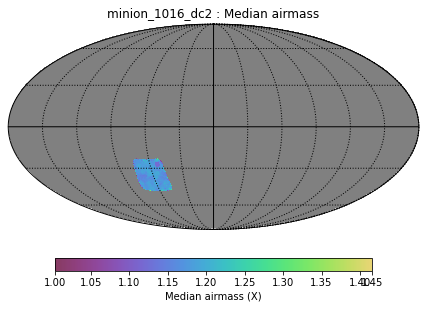

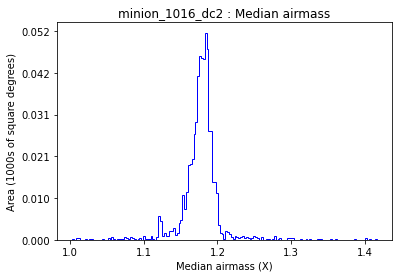

In [10]:
bundleDict['Median airmass'].plot()

In [11]:
# Let's look at those summary stats
pd.DataFrame([bundleDict[k].summaryValues for k in bundleDict], index=list(bundleDict.keys()))

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count
Mean airmass,1.196626,0.020968,1.196974,1.412943,1.002749,26,30,2822
Median airmass,1.177193,0.027106,1.178857,1.416064,1.002749,34,33,2822
Min airmass,1.012093,0.024586,1.003979,1.403240,1.001530,28,0,2822
Max airmass,1.552623,0.216229,1.519328,2.709891,1.002749,92,0,2822


In [12]:
# Another way to look at some of them ..
print('Median minimum airmass', bundleDict['Min airmass'].summaryValues['Median'])
print('Median median airmass', bundleDict['Median airmass'].summaryValues['Median'])
print('Median maximum airmass', bundleDict['Max airmass'].summaryValues['Median'])

Median minimum airmass 1.00397942475
Median median airmass 1.178856905385
Median maximum airmass 1.51932788444
